In [1]:
import numpy as np
import matplotlib.pyplot as plt

# importation des algos cma
import cma


C:\Users\t0252097\Desktop\Premier projet\pycma-master
C:\Users\t0252097


### (1+1)-Cholesky-CMA-ES

In [6]:
def updateStepSize(sigma, lbd, p_succ, d, p_target_succ, c_p):
    p_succ = (1-c_p)*p_succ + c_p * lbd
    sigma = sigma * np.exp(1/d * (p_succ - p_target_succ/(1-p_target_succ) * (1 - p_succ)))
    return sigma, p_succ

def updateCholesky(A, z, p_succ, c_cov, p_thresh):
    if p_succ < p_thresh :
        c_a = np.sqrt(1 - c_cov)
        A = c_a * A + c_a/np.linalg.norm(z) * (np.sqrt(1 + (1 - c_a**2) * np.linalg.norm(z)**2 / c_a**2) - 1) * A * np.outer(z,z) #z@z.T
    return A

def Cholesky_11_CMAES(objective, x0, sigma = 1, niter = 35000, p_target_succ = 2/11):
    n = len(x0)
    A = np.eye(n)
    p_succ = p_target_succ
    p_c = 0
    fct = [objective(x0)]
    
    #for i in range(niter):
    while fct[-1] > 1e-10 and len(fct) < niter:
        z = np.random.normal(size=n)
        x = x0 + sigma * A @ z
        f = objective(x)
        lbd = 1 * (f <= fct[-1])
        sigma, p_succ =  updateStepSize(sigma, lbd, p_succ, d = 1 + n/2, p_target_succ = 2/11, c_p = 1/12)
        
        if lbd == 1 :
            x0 = x
            fct.append(f)
            A = updateCholesky(A, z, p_succ, c_cov = 2/(n**2 + 6), p_thresh = 0.44)
        else : fct.append(fct[-1])
            
    return fct
            

In [50]:
from scipy.linalg import cholesky

def is_pos_def(A):
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

def updateCov(C, y, p_succ, p_c, c_c, c_cov, p_thresh):
    if p_succ < p_thresh :
        p_c = (1-c_c) * p_c + np.sqrt(c_c * (2-c_c)) * y
        C = (1-c_cov) * C + c_cov * np.outer(p_c, p_c)
    else:
        p_c = (1-c_c) * p_c
        C = (1-c_cov) * C + c_cov * (np.outer(p_c, p_c) + c_c * (2-c_c) * C)
    return C, p_c
        
def elitist_CMA(objective, x0, sigma = 1, niter = 35000, p_target_succ = 2/11):
    n = len(x0)
    C = np.eye(n)
    p_succ = p_target_succ
    p_c = 0
    fct = [objective(x0)]
    
    while fct[-1] > 1e-10 and len(fct) < niter:   
        if is_pos_def(C): A = cholesky(C)
        z = np.random.normal(size=n)
        x = x0 + sigma * A @ z
        f = objective(x)
        lbd = 1 * (f <= fct[-1])
        sigma, p_succ =  updateStepSize(sigma, lbd, p_succ, d = 1 + n/2, p_target_succ = 2/11, c_p = 1/12)
        
        if lbd == 1 :
            x0 = x
            fct.append(f)
            C, p_c = updateCov(C, x0, p_succ, p_c, c_c = 2/(n+2), c_cov = 2/(n**2+6), p_thresh = 0.44)
        else : fct.append(fct[-1])
            
    return fct

result = elitist_CMA(cma.ff.sphere, x0, sigma = 3, niter = 5000)

In [65]:
def faire_graph(list_fct_1, list_fct_2):
    a = sorted(list_fct_1, key = len)
    b = sorted(list_fct_2, key = len)
    del a[-3:-1]
    del a[0:2]
    del b[-3:-1]
    del b[0:2]
    
    to_plot = a[23]
    plt.semilogy(np.arange(len(to_plot)), to_plot, label = "Cholesky", color = 'b')
    if len(a[0]) == len(a[-1]):
        limit = [len(a[0]), len(a[-1])]
        last_value = [u[-1] for u in a]
        pt = [min(last_value), max(last_value)]
        plt.plot(limit, pt, marker = '*', color = 'b')
    else:
        limit = [len(a[0]), len(a[-1])]
        pt = [to_plot[-1], to_plot[-1]]
        plt.plot(limit, pt, marker = '*', color = 'b')
    
    to_plot = b[23]
    plt.semilogy(np.arange(len(to_plot)), to_plot, label = "Evolution Path", color = 'r')
    if len(b[0]) == len(b[-1]):
        limit = [len(b[0]), len(b[-1])]
        last_value = [u[-1] for u in b]
        pt = [min(last_value), max(last_value)]
        plt.plot(limit, pt, marker = '*', color = 'r')
    else:
        limit = [len(b[0]), len(b[-1])]
        pt = [to_plot[-1], to_plot[-1]]
        plt.plot(limit, pt, marker = '*', color = 'r')
    
    plt.legend()
    plt.title("Comparaison du CMA utilisant cholesky et le (1+1)-CMA classique")
    plt.show()

#### Sphere

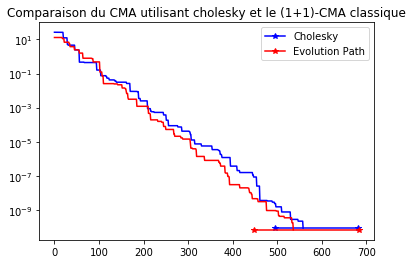

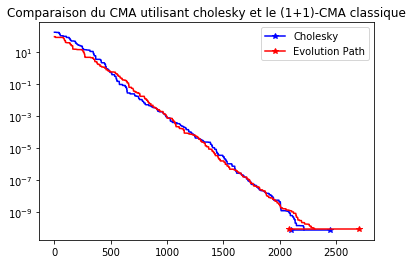

In [55]:
# Sphere
dim = 5
list_1 = []
list_2 = []
for i in range(51):
    x0 = np.random.uniform(-1, 5, dim)
    
    result = Cholesky_11_CMAES(cma.ff.sphere, x0, sigma = 3, niter = 5000)
    list_1.append(result)
    
    result = elitist_CMA(cma.ff.sphere, x0, sigma = 3, niter = 5000)
    list_2.append(result)

faire_graph(list_1, list_2)

dim = 20
list_1 = []
list_2 = []
for i in range(51):
    x0 = np.random.uniform(-1, 5, dim)
    
    result = Cholesky_11_CMAES(cma.ff.sphere, x0, sigma = 3, niter = 5000)
    list_1.append(result)
    
    result = elitist_CMA(cma.ff.sphere, x0, sigma = 3, niter = 5000)
    list_2.append(result)

faire_graph(list_1, list_2)

#### Elli

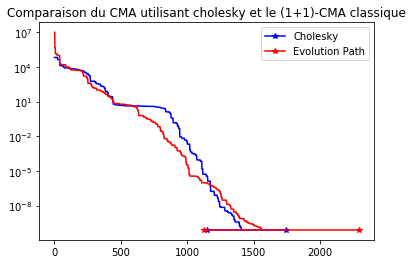

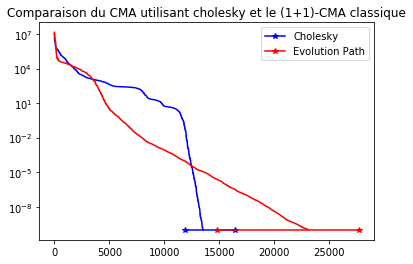

In [46]:
# Elli
dim = 5
list_1 = []
list_2 = []
for i in range(51):
    x0 = np.random.uniform(-1, 5, dim)
    
    result = Cholesky_11_CMAES(cma.ff.elli, x0, sigma = 3, niter = 5000)
    list_1.append(result)
    
    result = elitist_CMA(cma.ff.elli, x0, sigma = 3, niter = 5000)
    list_2.append(result)

faire_graph(list_1, list_2)

dim = 20
list_1 = []
list_2 = []
for i in range(51):
    x0 = np.random.uniform(-1, 5, dim)
    
    result = Cholesky_11_CMAES(cma.ff.elli, x0, sigma = 3)
    list_1.append(result)
    
    result = elitist_CMA(cma.ff.elli, x0, sigma = 3)
    list_2.append(result)

faire_graph(list_1, list_2)

#### Rastrigin

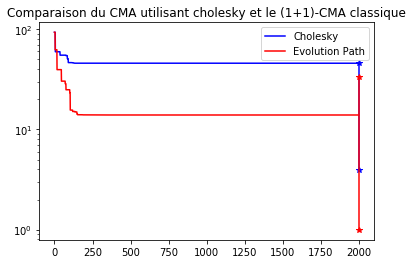

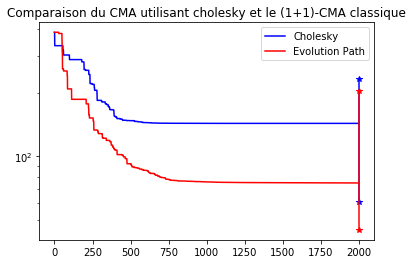

In [66]:
# Rastrigin
dim = 5
list_1 = []
list_2 = []
for i in range(51):
    x0 = np.random.uniform(-1, 5, dim)
    
    result = Cholesky_11_CMAES(cma.ff.rastrigin, x0, sigma = 3, niter = 2000)
    list_1.append(result)
    
    result = elitist_CMA(cma.ff.rastrigin, x0, sigma = 3, niter = 2000)
    list_2.append(result)

faire_graph(list_1, list_2)

dim = 20
list_1 = []
list_2 = []
for i in range(51):
    x0 = np.random.uniform(-1, 5, dim)
    
    result = Cholesky_11_CMAES(cma.ff.rastrigin, x0, sigma = 3, niter = 2000)
    list_1.append(result)
    
    result = elitist_CMA(cma.ff.rastrigin, x0, sigma = 3, niter = 2000)
    list_2.append(result)

faire_graph(list_1, list_2)

### Suite: Ajout des contraintes